In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import re
import matplotlib.pyplot as plt

%matplotlib inline
# ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [11]:
df = pd.read_csv('./felix_clening.csv')

In [3]:
# Extract the year from 'Analysis Date'
df['year'] = df['Analysis Date'].apply(lambda x: x.split('-')[0])

df['polygon_x'] = df['polygon'].apply(lambda x: x['x'])
df['polygon_y'] = df['polygon'].apply(lambda x: x['y'])
df['month'] = df['Analysis Date'].apply(lambda x: x.split('-')[1])
df['day'] = df['Analysis Date'].apply(lambda x: x.split('-')[2])

df['vegetation'] = (df['indextype'] == 'NDVI') & (df['averagevalue'] >= 0.15)
df = df.drop(['polygon', 'soil_id'] , axis = 1)

# Modify the 'combined' column to include year
df['combined'] = df['polygon_x'].astype(str) + '_' + df['polygon_y'].astype(str) + '_' + df['year'].astype(str)

# Assign unique ID based on the grouped column
df['id'] = df.groupby('combined').ngroup() + 1

# Drop the combined column and other temporary columns
df = df.drop(columns=['combined', 'polygon_x', 'polygon_y', 'year'])

In [4]:
df = df[df['indextype'] == 'NDVI']
df = df.drop(columns=['indextype', 'year contour', 'month', 'day', 'vegetation', 'type_culture_name'])
df = df.rename(columns={'culture_name': 'class'})
df = df.rename(columns={'averagevalue': 'red'})
df = df.rename(columns={'Analysis Date': 'date'})
df['date'] = pd.to_datetime(df['date'])

In [5]:
label_encoder = LabelEncoder() 
  
# Encode labels in column 'class'. 
# df['class']= label_encoder.fit_transform(df['class']) 
df['district_name']= label_encoder.fit_transform(df['district_name']) 
df['soil_name']= label_encoder.fit_transform(df['soil_name']) 
df['class'].unique() 

array(['Картофель', 'Соя', 'Ячмень', 'Кукуруза', 'Пшеница', 'Свекла',
       'Люцерна', 'Яровой', 'Фасоль', 'Клевер', 'Арбуз', 'Лук', 'Томат',
       'Морковь', 'Рапс', 'Помидор', 'Софлор', 'Сил', 'Лук-Морковка',
       'Капуста', 'Экпарцет', 'Подсолнечник'], dtype=object)

In [6]:
# Convert date to multiple columns (year, month, day)
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day
df.drop('date', axis=1, inplace=True)

# Splitting data    
X = df.drop(['class', 'id', 'year', 'day'], axis=1) 
y = df['class']

In [7]:
# Pivot table
pivot_df = df.pivot_table(index='id', columns='month', values='red', aggfunc='mean')

# Fill NaN values (assuming you want to fill with zeros, adjust if needed)
# pivot_df = pivot_df.fillna(0)

# Rename columns as needed
pivot_df.columns = [f'red_{col}_month' for col in pivot_df.columns]

# Reset the index so 'id' becomes a column
pivot_df = pivot_df.reset_index()

# Assuming each 'id' has a unique 'class', get the 'class' value for each 'id' and add to the pivot dataframe
pivot_df['class'] = pivot_df['id'].map(df.drop_duplicates(subset='id').set_index('id')['class'])
pivot_df['elevation_contour'] = pivot_df['id'].map(df.drop_duplicates(subset='id').set_index('id')['elevation_contour'])
pivot_df['district_name'] = pivot_df['id'].map(df.drop_duplicates(subset='id').set_index('id')['district_name'])
pivot_df['soil_name'] = pivot_df['id'].map(df.drop_duplicates(subset='id').set_index('id')['soil_name'])

# Reordering columns
pivot_df = pivot_df[['red_4_month', 'red_5_month', 'red_6_month', 'red_8_month', 'red_9_month', 'id', 'elevation_contour', 'district_name', 'soil_name', 'class']]


In [8]:
pivot_df['class'].value_counts()

class
Пшеница         231
Ячмень          193
Кукуруза        183
Свекла          163
Люцерна         120
Картофель        36
Соя              21
Лук               7
Арбуз             6
Рапс              5
Томат             5
Капуста           4
Лук-Морковка      4
Софлор            3
Экпарцет          3
Сил               2
Помидор           2
Клевер            2
Яровой            2
Морковь           1
Фасоль            1
Подсолнечник      1
Name: count, dtype: int64

In [9]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   red_4_month        885 non-null    float64
 1   red_5_month        890 non-null    float64
 2   red_6_month        994 non-null    float64
 3   red_8_month        794 non-null    float64
 4   red_9_month        616 non-null    float64
 5   id                 995 non-null    int64  
 6   elevation_contour  995 non-null    int64  
 7   district_name      995 non-null    int64  
 8   soil_name          995 non-null    int64  
 9   class              995 non-null    object 
dtypes: float64(5), int64(4), object(1)
memory usage: 77.9+ KB


In [10]:
# Grouping by the 'class' column and computing the mean for each group
means_by_class = pivot_df.groupby('class')[['red_4_month', 'red_5_month', 'red_6_month', 'red_8_month', 'red_9_month']].mean()

print(means_by_class)


              red_4_month  red_5_month  red_6_month  red_8_month  red_9_month
class                                                                        
Арбуз            0.130333     0.251833     0.219167     0.290000     0.190400
Капуста          0.100500     0.186750     0.178750     0.612000     0.585667
Картофель        0.053500     0.106036     0.250222     0.180714     0.107464
Клевер           0.233000     0.251000     0.217000     0.090000     0.082000
Кукуруза         0.068899     0.126081     0.168415     0.243982     0.188265
Лук              0.035286     0.052357     0.076571     0.205714     0.181857
Лук-Морковка     0.076250     0.185250     0.128250     0.056500     0.053500
Люцерна          0.174505     0.324549     0.225417     0.202505     0.194099
Морковь          0.037000     0.044000     0.084000          NaN          NaN
Подсолнечник     0.063000     0.065000     0.129000          NaN          NaN
Помидор          0.051000     0.054000     0.092000     0.599000

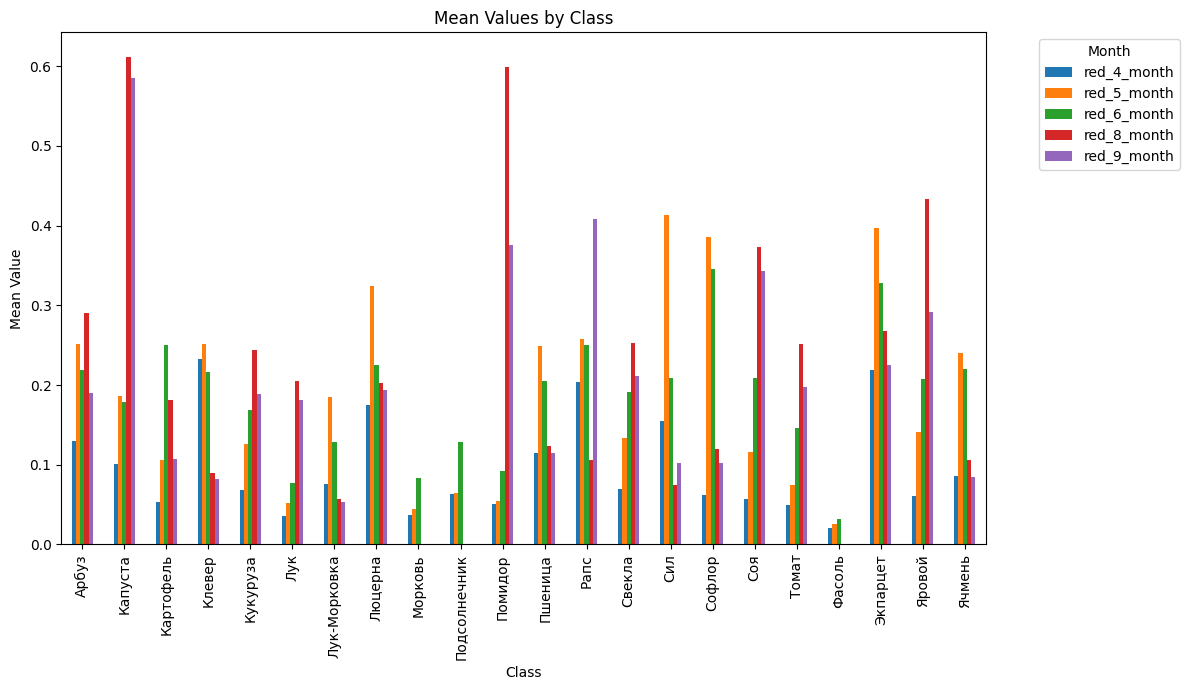

In [11]:
import matplotlib.pyplot as plt

# Plotting the means for each class
means_by_class.plot(kind='bar', figsize=(12, 7))

plt.title('Mean Values by Class')
plt.ylabel('Mean Value')
plt.xlabel('Class')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [12]:
# Splitting the data
X = df.drop(['class'], axis=1)  # Features excluding 'id' and 'class'
y = df['class']  # Target variable

In [13]:
class_counts = y.value_counts()
single_sample_classes = class_counts[class_counts <= 184].index
filter_mask = ~y.isin(single_sample_classes)
X = X[filter_mask]
y = y[filter_mask]

In [14]:
y.value_counts()

class
Пшеница    231
Ячмень     193
Name: count, dtype: int64

In [15]:
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [17]:
imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [14]:
# Defining the parameter grid for GradientBoostingClassifier
param_dist = {
    'n_estimators': [10, 50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Instantiating GradientBoostingClassifier
gbm = GradientBoostingClassifier()

# Setting up RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbm, param_distributions=param_dist, n_iter=100, scoring='accuracy', 
    cv=5, verbose=1, n_jobs=-1
)

# Fitting the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Getting the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Evaluate on the test set
print("Test Set Score:", random_search.score(X_test, y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.01}
Best Score: 0.5121604938271604
Test Set Score: 0.4885057471264368


In [16]:
y.value_counts()

class
3    140
5    116
2     97
4     92
1     74
6     59
Name: count, dtype: int64